In [1]:
!pip install torch
!pip install matplotlib

In [2]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = "sample_data/bicycle.txt"

with open(file_path, "r") as file:
    lines = file.readlines()

data = []
for line in lines:
    x, y = map(float, line.strip().split())
    data.append([x, y])

data = torch.tensor(data).to(device)

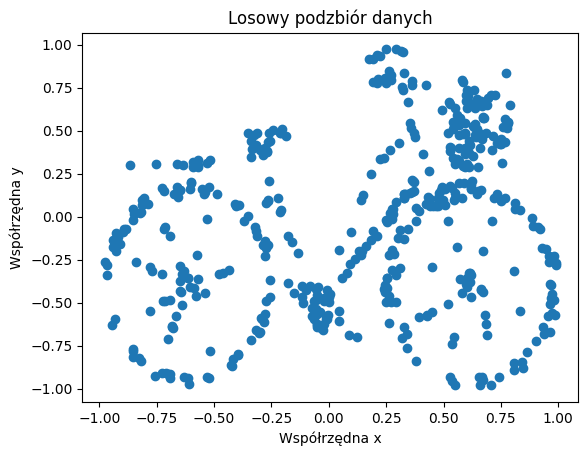

In [3]:
subset_size = 500
random_subset = data[torch.randperm(data.size(0))[:subset_size]]

plt.scatter(random_subset[:, 0].cpu(), random_subset[:, 1].cpu())
plt.title('Losowy podzbiór danych')
plt.xlabel('Współrzędna x')
plt.ylabel('Współrzędna y')
plt.show()

In [4]:
T = 1000
min_beta = 0.0001
max_beta = 0.02
betas = torch.linspace(min_beta, max_beta, T)
alphas = 1 - betas
alpha_bars = torch.tensor(
            [torch.prod(alphas[: i + 1]) for i in range(len(alphas))])

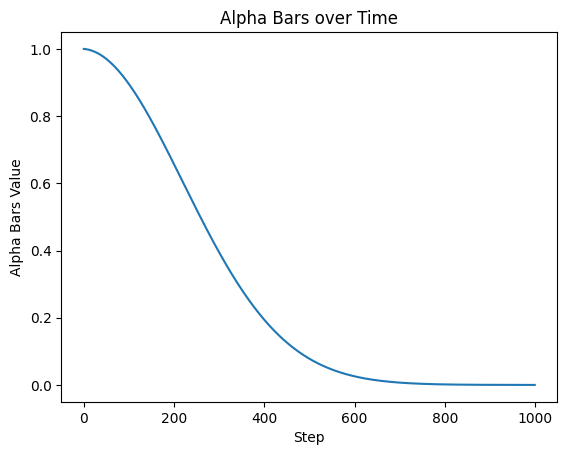

In [5]:
plt.plot(alpha_bars)
plt.title('Alpha Bars over Time')
plt.xlabel('Step')
plt.ylabel('Alpha Bars Value')
plt.show()

In [6]:
def sigmoidal_sequence(length, midpoint=0.5, steepness=5):
    values = torch.arange(0, length).float()
    return 1 / (1 + torch.exp(steepness * (values / length - midpoint)))

alpha_bars_sigmoid = sigmoidal_sequence(T, midpoint=0.5, steepness=10)

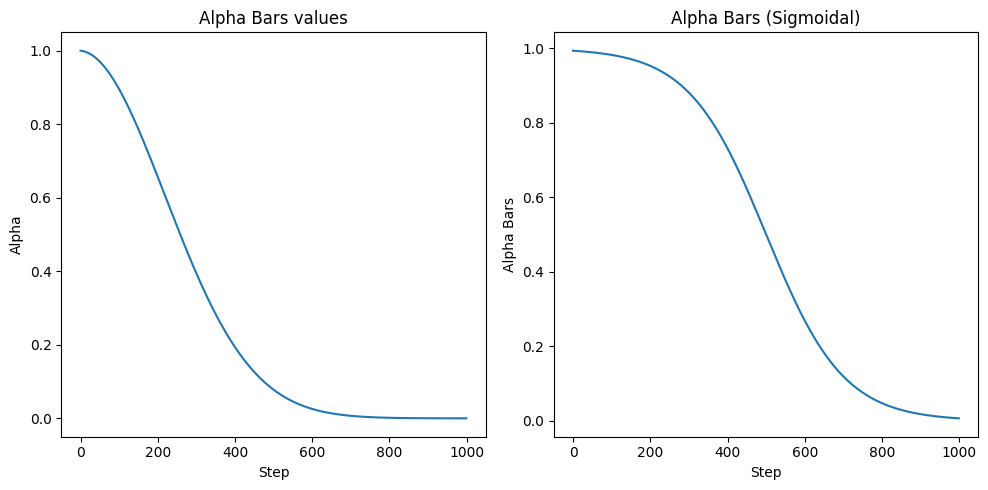

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(alpha_bars)
plt.title('Alpha Bars values')
plt.xlabel('Step')
plt.ylabel('Alpha')

plt.subplot(1, 2, 2)
plt.plot(alpha_bars_sigmoid)
plt.title('Alpha Bars (Sigmoidal)')
plt.xlabel('Step')
plt.ylabel('Alpha Bars')

plt.tight_layout()
plt.show()

In [8]:
alpha_bars_sigmoid = alpha_bars_sigmoid.to(device)
alphas = alpha_bars_sigmoid[1:] / alpha_bars_sigmoid[:-1]
alphas = torch.cat((torch.tensor([0.9999]).to(device), alphas))
betas = 1 - alphas

alphas = alphas.to(device)
betas = betas.to(device)

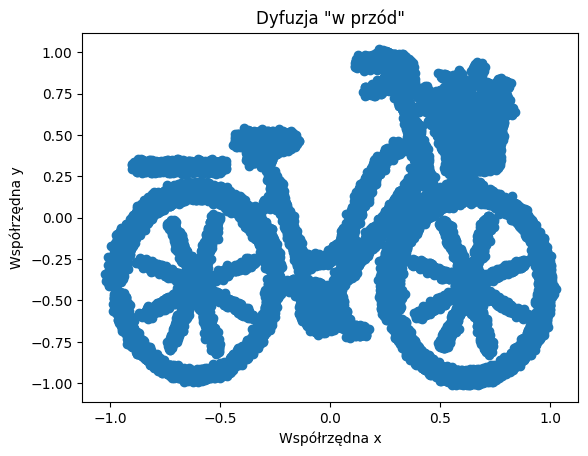

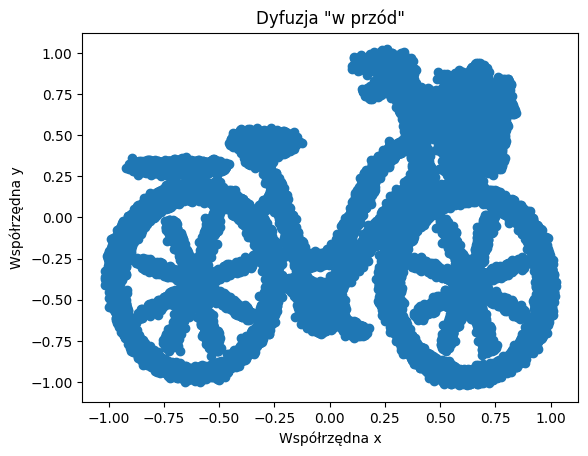

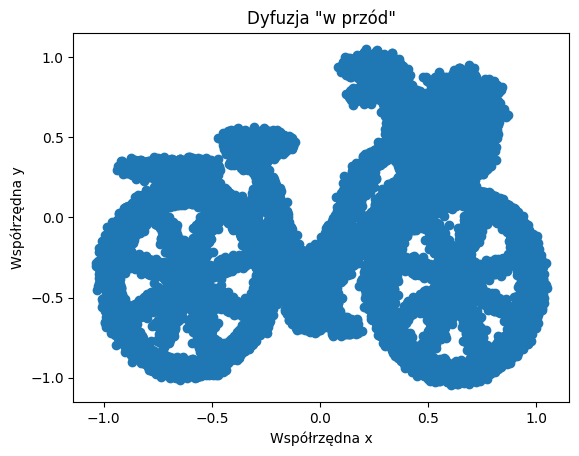

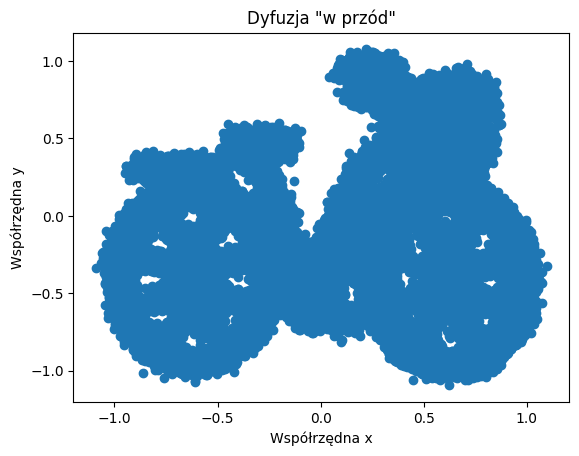

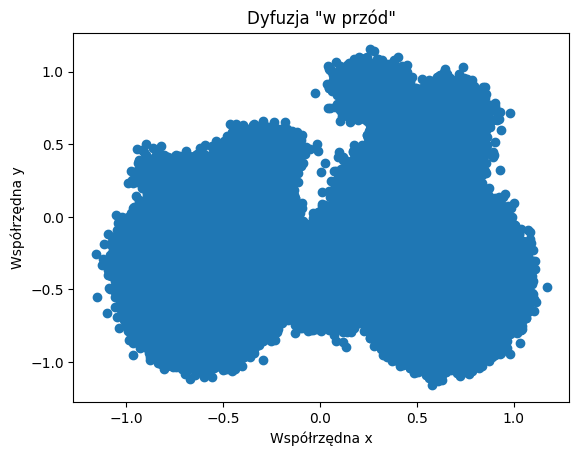

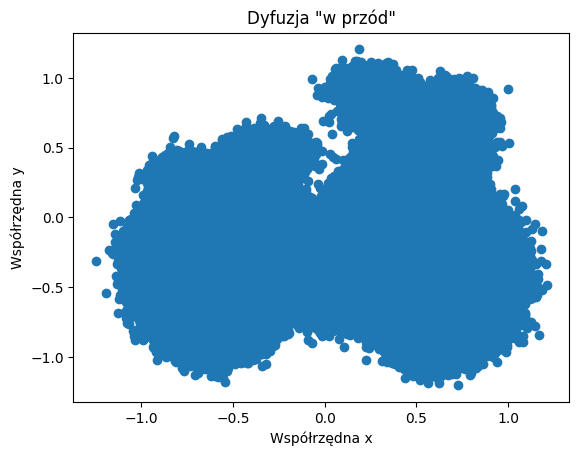

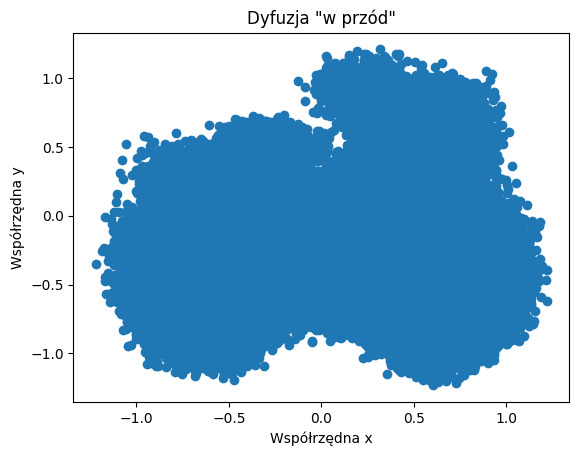

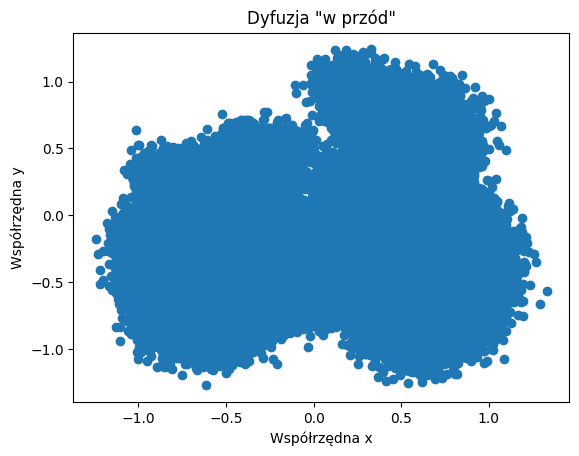

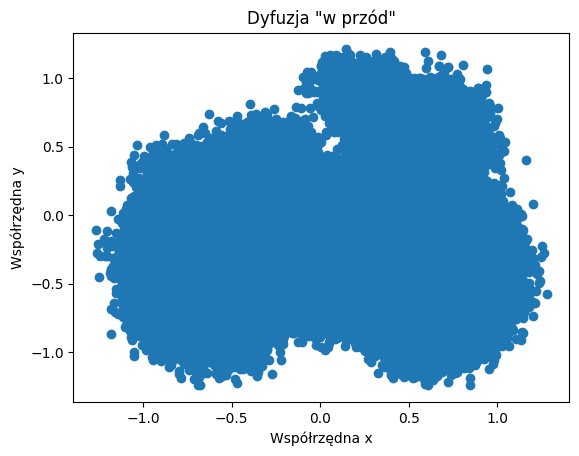

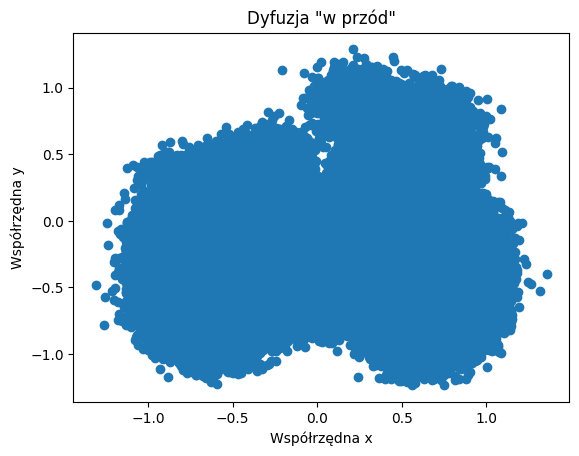

In [9]:
sequence_length = 1000

tmp_data = data

def forward_diffusion(data2, eta, t):
    z = data2 * alphas[t]**0.5 + eta * betas[t]**0.5
    return z

for i in range(0, sequence_length, 100):
    eta = torch.randn_like(data)
    tmp_data = forward_diffusion(data, eta, i)

    plt.scatter(tmp_data[:, 0].cpu(), tmp_data[:, 1].cpu())
    plt.title('Dyfuzja "w przód"')
    plt.xlabel('Współrzędna x')
    plt.ylabel('Współrzędna y')
    plt.show()


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class LearnableSinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_size=50, hidden_size=128):
        super(LearnableSinusoidalEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.position_encoding = nn.EmbeddingBag(1000, embedding_size).to(device)

        self.linear1 = nn.Linear(embedding_size, hidden_size).to(device)
        self.linear2 = nn.Linear(hidden_size, hidden_size).to(device)

    def forward(self, t):
        offset = torch.tensor([0]).to(device)
        encoding = self.position_encoding(t, offset).to(device)
        x = torch.relu(self.linear1(encoding))
        x = self.linear2(x)

        return x

class ConditionalDenseLayer(nn.Module):
    def __init__(self, input_size=2, hidden_size=128):
        super(ConditionalDenseLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.linear_x = nn.Linear(input_size, hidden_size)
        self.sinusoidal_embedding = LearnableSinusoidalEmbedding()

    def forward(self, x, t):

        x_linear = self.linear_x(x)
        t_embedding = self.sinusoidal_embedding(t)
        x_combined = x_linear + t_embedding
        x_combined = torch.relu(x_combined)

        return x_combined

class ConditionalDenseLayerNoRelu(nn.Module):
    def __init__(self, input_size=128, hidden_size=2):
        super(ConditionalDenseLayerNoRelu, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.linear_x = nn.Linear(input_size, hidden_size).to(device)
        self.sinusoidal_embedding = LearnableSinusoidalEmbedding()

    def forward(self, x, t):

        x_linear = x
        t_embedding = self.sinusoidal_embedding(t)
        x_combined = self.linear_x(x_linear + t_embedding)

        return x_combined

class ConditionalDenseModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3):
        super(ConditionalDenseModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = nn.ModuleList([ConditionalDenseLayer(), ConditionalDenseLayer(128), ConditionalDenseLayer(128), ConditionalDenseLayerNoRelu()])

    def forward(self, x, t):
        for layer in self.layers:
            x = layer(x, t)

        return x

input_size = 64
batch_size = 64

print(data[0])
data = data.to(device)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

model = ConditionalDenseModel(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in dataloader:
    x, t = batch.to(device), torch.tensor([1]).to(device)
    print(x.shape)
    output = model(x, t)
    print("Output shape:", output.shape)
    break

tensor([0.2370, 1.0000], device='cuda:0')
torch.Size([64, 2])
Output shape: torch.Size([64, 2])


In [11]:
for batch in dataloader:
    x, t = batch.to(device), torch.randint(0, T, (1,)).to(device)
    print(x.shape)
    output = model(x, t)
    print("Output shape:", output.shape)
    break

torch.Size([64, 2])
Output shape: torch.Size([64, 2])


In [12]:
print(model.state_dict)

<bound method Module.state_dict of ConditionalDenseModel(
  (layers): ModuleList(
    (0): ConditionalDenseLayer(
      (linear_x): Linear(in_features=2, out_features=128, bias=True)
      (sinusoidal_embedding): LearnableSinusoidalEmbedding(
        (position_encoding): EmbeddingBag(1000, 50, mode='mean')
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1-2): 2 x ConditionalDenseLayer(
      (linear_x): Linear(in_features=128, out_features=128, bias=True)
      (sinusoidal_embedding): LearnableSinusoidalEmbedding(
        (position_encoding): EmbeddingBag(1000, 50, mode='mean')
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (3): ConditionalDenseLayerNoRelu(
      (linear_x): Linear(in_features=128, out_features=2, bias=True)
      (sinusoidal_embedding): Learnab

In [13]:
def test_results(modelx, num_samples=1000):
    with torch.no_grad():

        x = torch.randn(num_samples, 2).to(device)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(x[:, 0].cpu(), x[:, 1].cpu())


        for t in range(T-1, -1, -1):
            eta_theta = modelx(x, torch.tensor([t]).to(device)).cpu().detach()
            alpha_t = alphas[t]
            alpha_bar = alpha_bars_sigmoid[t]
            beta_t = betas[t]

            x = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_bar).sqrt() * eta_theta.to(device))

            if t > 0:
                z = torch.randn(num_samples, 2).to(device)

                sigma_t = beta_t**0.5
                x = x + sigma_t * z


        plt.subplot(1, 2, 2)
        plt.scatter(x[:, 0].cpu(), x[:, 1].cpu())

        plt.tight_layout()
        plt.show()


In [39]:
losses = []
criterion = nn.MSELoss()
save_every = 20
num_epochs = 100

for epoch in range(num_epochs):
    lossss = 0
    for batch in dataloader:
        clean_data = batch.to(device)

        noise = torch.randn_like(clean_data)
        noise_level = torch.randint(0, T, (1,)).to(device)
        noisy_data = forward_diffusion(clean_data, noise, noise_level)

        model.train()
        optimizer.zero_grad()

        predicted_noise = model(noisy_data, torch.tensor([noise_level]).to(device))

        loss = criterion(predicted_noise, noise)

        loss.backward()
        optimizer.step()

        losses.append(loss.detach().item())
        lossss += loss.detach().item()

    if epoch % save_every == save_every-1:
        print(f"Epoch {epoch}, Loss: {lossss}")
        torch.save(model.state_dict(), f"model_checkpoint_epoch{epoch}.pt")


Epoch 19, Loss: 695.6516054868698
Epoch 39, Loss: 674.4000440835953
Epoch 59, Loss: 671.3669771552086
Epoch 79, Loss: 658.1196359992027
Epoch 99, Loss: 663.1778073906898


In [23]:
print(len(dataloader.dataset)//64)

788


In [24]:
losses_tensor = torch.tensor(losses)

loss_row = len(dataloader.dataset)//64 + 1

losses_2D = losses_tensor.view(1000, loss_row)

In [32]:
for i in range(49, 1000,50):
    print(f'Epoch {i}, Loss: {losses_2D[i].sum()}')

Epoch 49, Loss: 704.474609375
Epoch 99, Loss: 688.3294677734375
Epoch 149, Loss: 675.8016357421875
Epoch 199, Loss: 664.2869873046875
Epoch 249, Loss: 659.1357421875
Epoch 299, Loss: 654.81640625
Epoch 349, Loss: 647.1624755859375
Epoch 399, Loss: 651.7364501953125
Epoch 449, Loss: 646.66455078125
Epoch 499, Loss: 646.372314453125
Epoch 549, Loss: 647.6544189453125
Epoch 599, Loss: 648.7939453125
Epoch 649, Loss: 641.3135986328125
Epoch 699, Loss: 643.0340576171875
Epoch 749, Loss: 638.5812377929688
Epoch 799, Loss: 642.5721435546875
Epoch 849, Loss: 638.7284545898438
Epoch 899, Loss: 646.09765625
Epoch 949, Loss: 646.5692749023438
Epoch 999, Loss: 641.1201171875


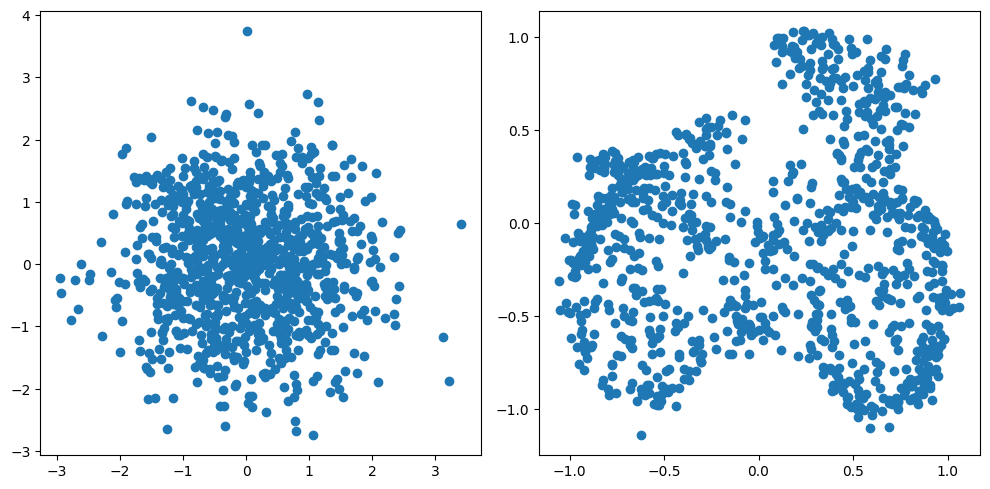

In [40]:
test_results(model)

In [33]:
def test_results_steps(modelx, num_samples=1000):
    with torch.no_grad():

        n = 100

        x = torch.randn(num_samples, 2).to(device)

        plt.scatter(x[:, 0].cpu(), x[:, 1].cpu())
        plt.show()


        for t in range(T-1, -1, -1):
            eta_theta = modelx(x, torch.tensor([t]).to(device)).cpu().detach()
            alpha_t = alphas[t]
            alpha_bar = alpha_bars_sigmoid[t]
            beta_t = betas[t]

            x = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_bar).sqrt() * eta_theta.to(device))

            if t > 0:
                z = torch.randn(num_samples, 2).to(device)

                sigma_t = beta_t**0.5
                x = x + sigma_t * z

            if t%n == n - 1:
                plt.scatter(x[:, 0].cpu(), x[:, 1].cpu())
                plt.show()

        plt.scatter(x[:, 0].cpu(), x[:, 1].cpu())
        plt.show()


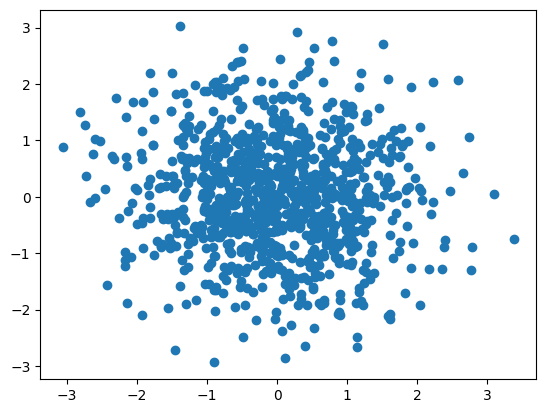

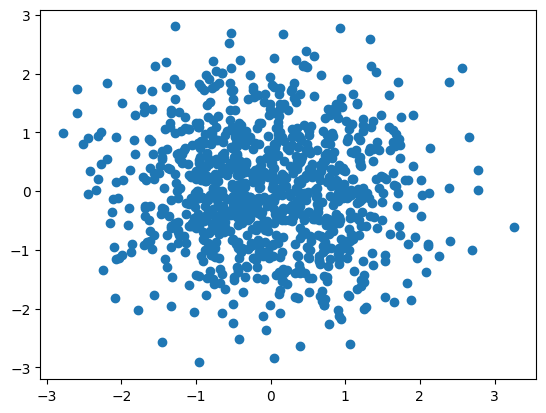

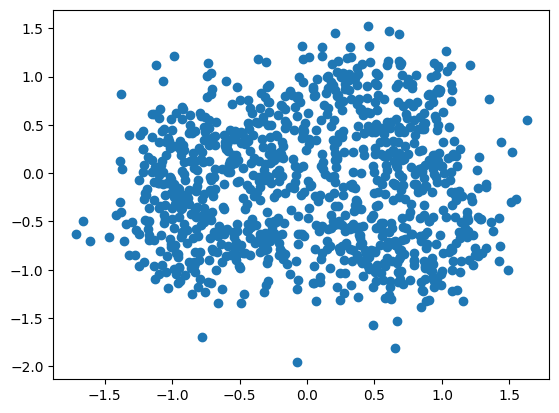

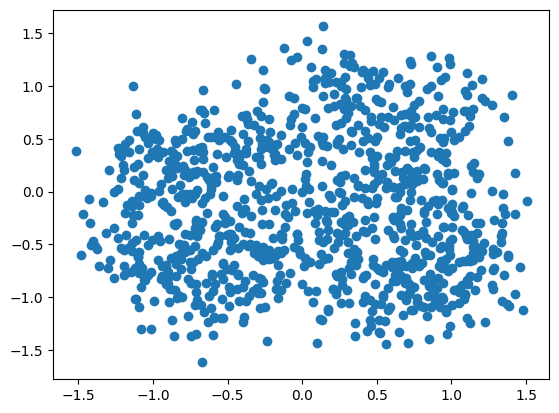

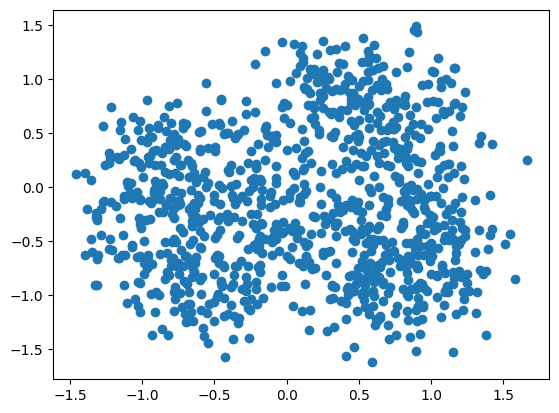

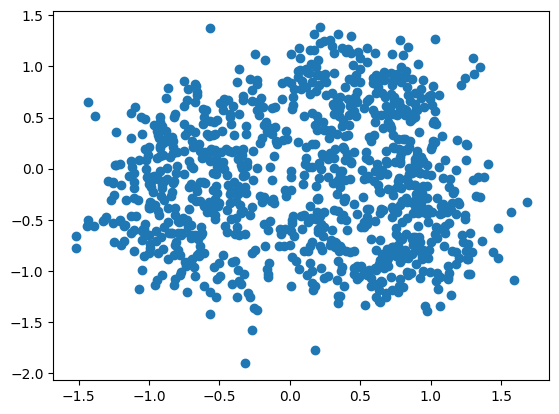

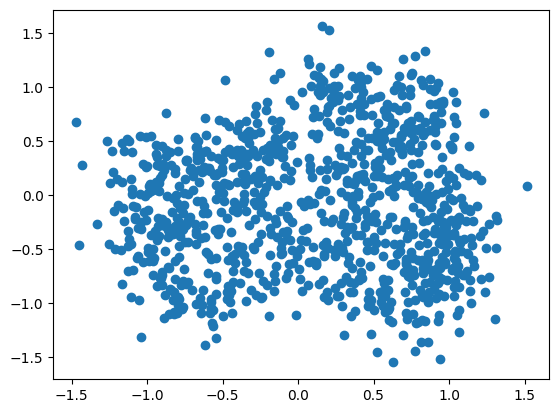

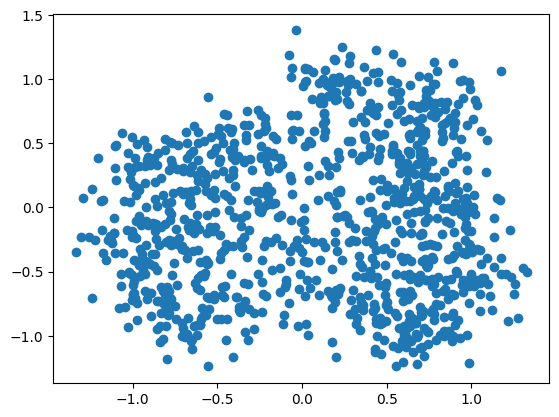

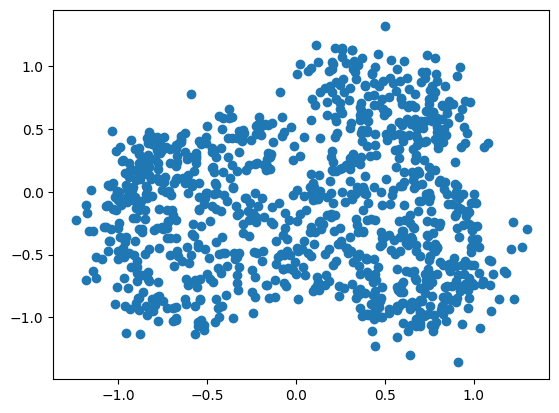

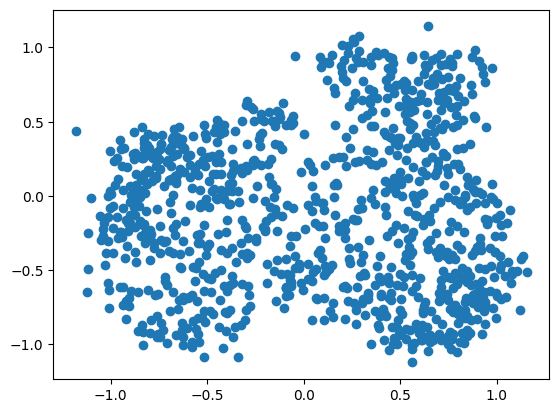

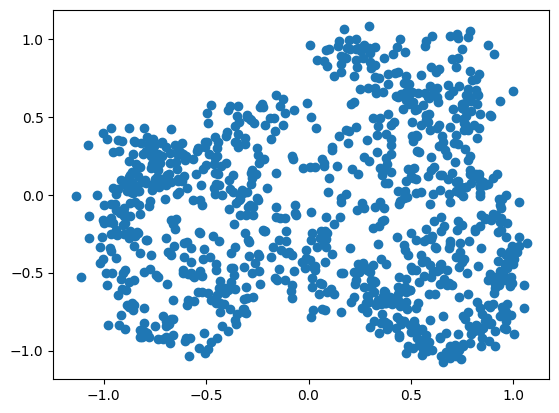

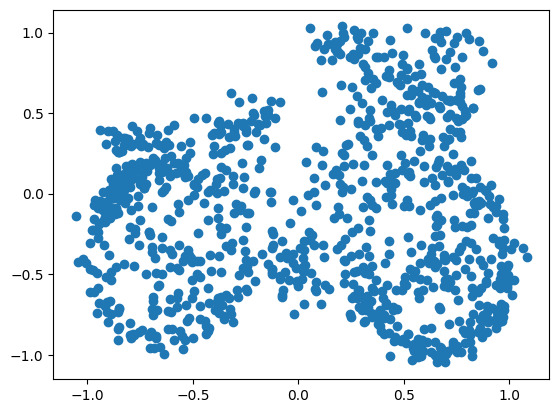

In [41]:
test_results_steps(model)

In [ ]:
# Wczytaj wag zapisanego modelu
model2 = ConditionalDenseModel(input_size).to(device)

checkpoint_path = "model_checkpoint_epoch659.pt"
checkpoint = torch.load(checkpoint_path)

model2.load_state_dict(checkpoint)

<All keys matched successfully>

Epoch 99, Loss: 688.3294677734375


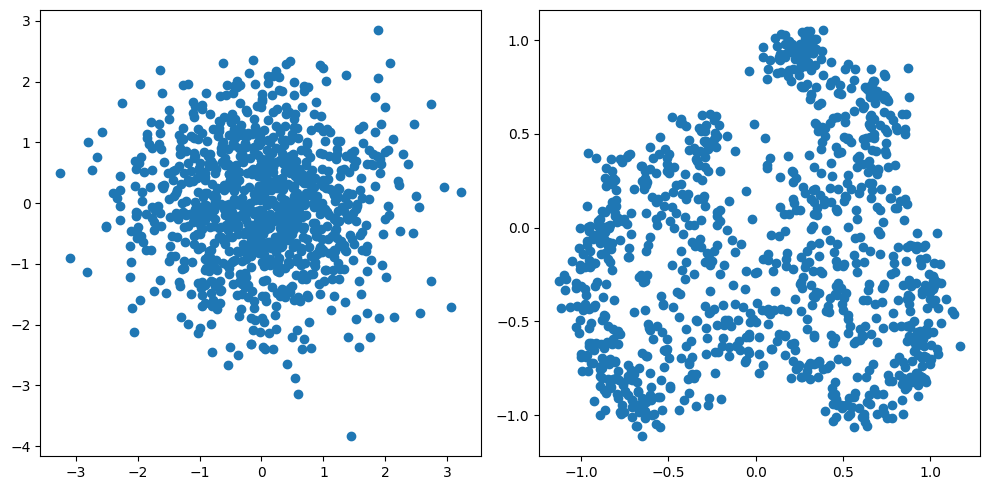

Epoch 199, Loss: 664.2869873046875


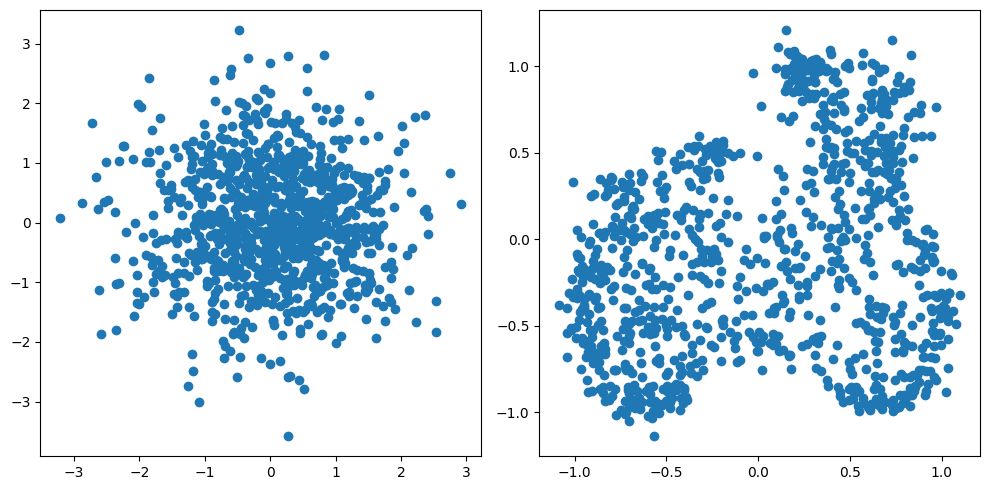

Epoch 299, Loss: 654.81640625


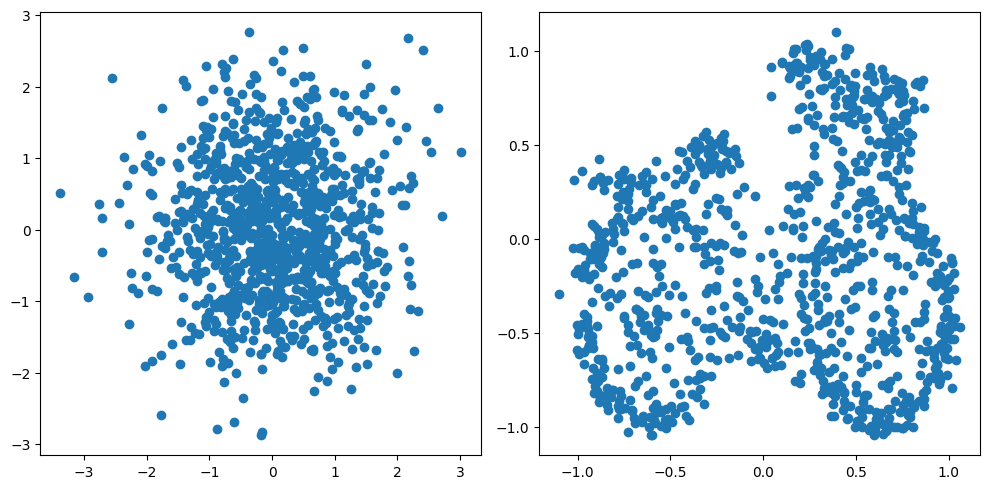

Epoch 399, Loss: 651.7364501953125


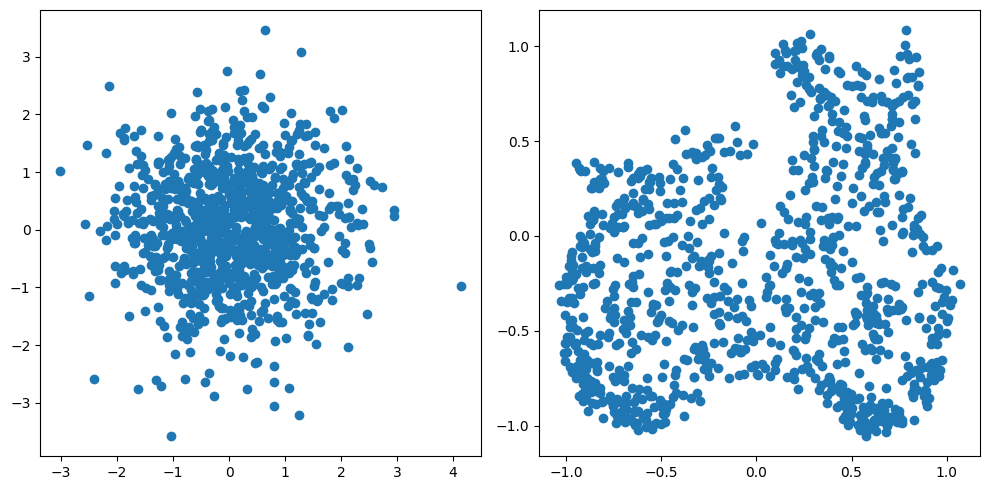

Epoch 499, Loss: 646.372314453125


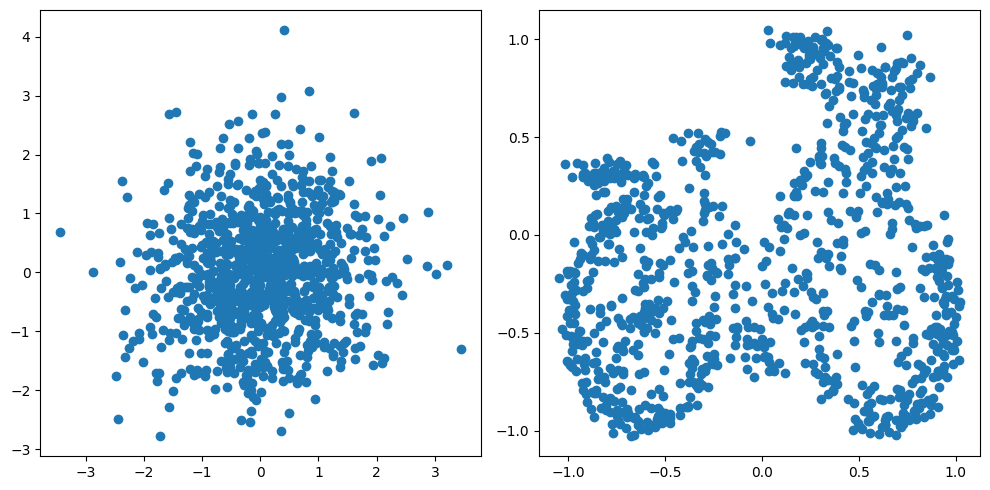

Epoch 599, Loss: 648.7939453125


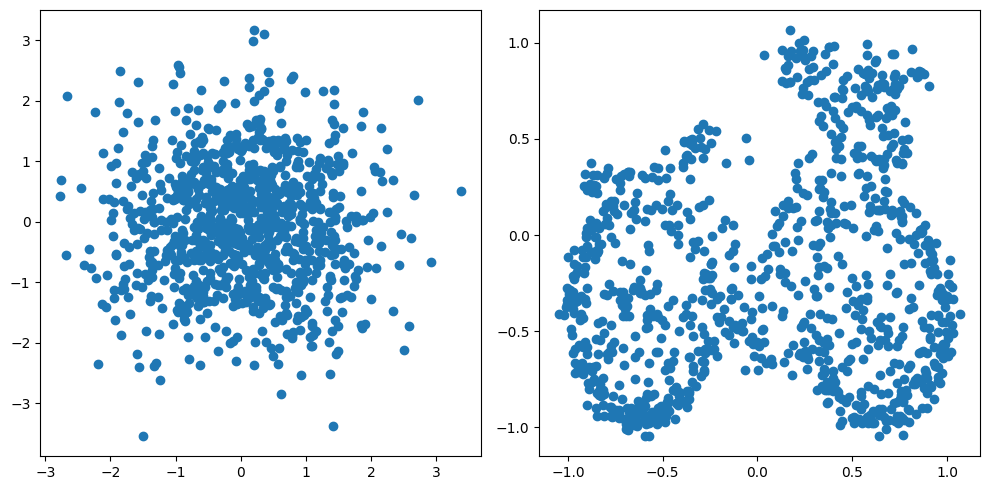

Epoch 699, Loss: 643.0340576171875


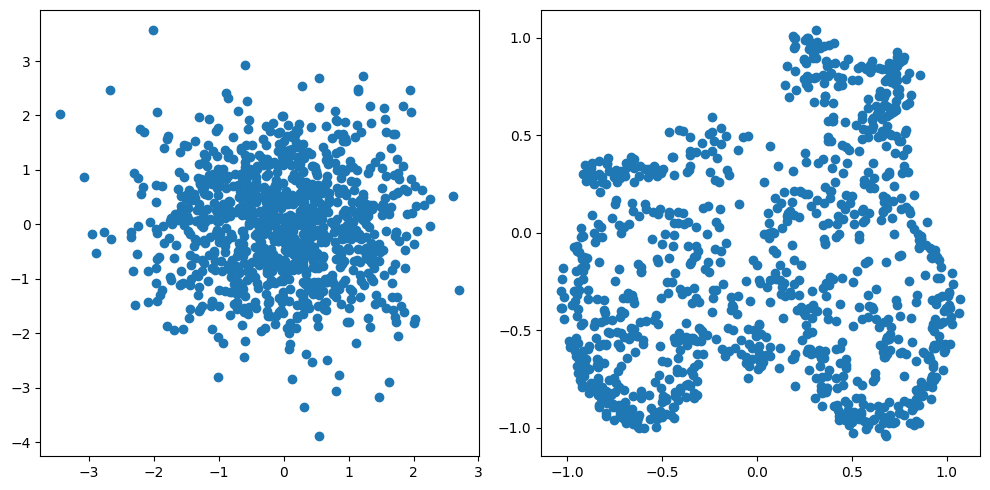

Epoch 799, Loss: 642.5721435546875


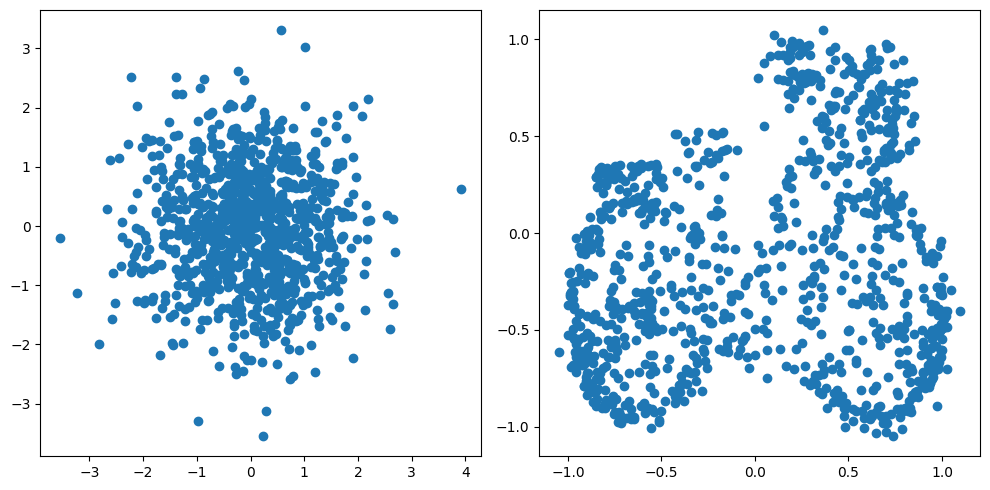

Epoch 899, Loss: 646.09765625


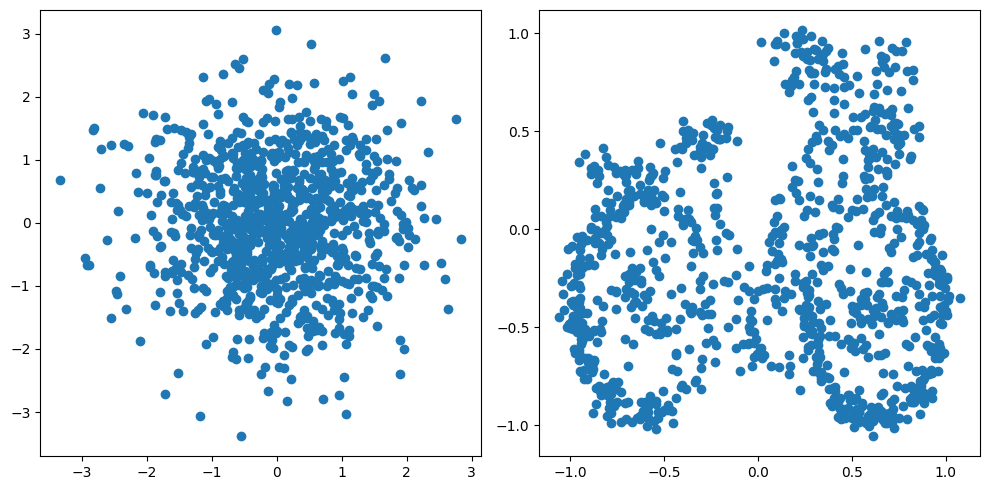

Epoch 999, Loss: 641.1201171875


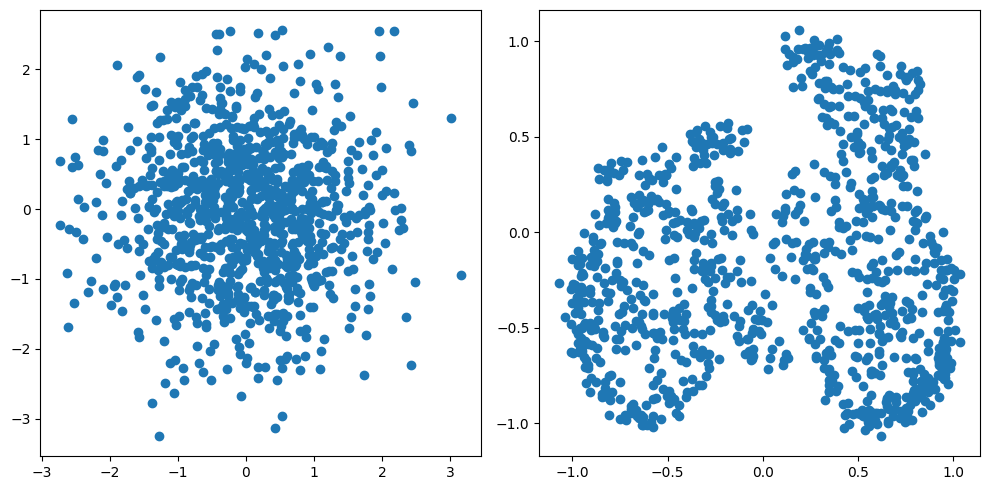

In [37]:
epo = [99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

for i in epo:
    print(f'Epoch {i}, Loss: {losses_2D[i].sum()}')
    model_tmp = ConditionalDenseModel(input_size).to(device)

    checkpoint_path = "model_checkpoint_epoch" + str(i) + ".pt"
    checkpoint = torch.load(checkpoint_path)

    model_tmp.load_state_dict(checkpoint)

    test_results(model_tmp)